In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import networkx as nx
from queue import Queue


In [8]:
import base64
import shutil
import PIL
import requests
from PIL import Image

def draw(tree):

    graph_txt = "graph LR;"+";".join([
        f"{str(edge[0]).replace('<','').replace('>','')}"
        f"-"
        f"->{str(edge[1]).replace('<','').replace('>','')}"
        for edge in tree.edges
    ])
    
    graphbytes = graph_txt.encode("ascii")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    url = "https://mermaid.ink/img/" + base64_string

    response = requests.get(url, stream=True)

    with open('tmp.png', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    return Image.open('tmp.png')

# BFS

In [10]:
tree = nx.DiGraph()
nodes_to_explore = Queue()

x = 0
tree.add_node(x)
nodes_to_explore.put(x)

n=0
MAX_NODES = 25
MAX_DEPTH = 3


while x < MAX_NODES:

    n = nodes_to_explore.get()
    if len(nx.shortest_path(tree, source=0, target=n)) > MAX_DEPTH:
        break
    tree.add_edge(n, x+1, action=f"{n}->{x+1}")
    nodes_to_explore.put(x+1)
    tree.add_edge(n, x+2, action=f"{n}->{x+2}")
    nodes_to_explore.put(x+2)
    x += 2


leaves = [node for node in tree.nodes() if tree.in_degree(node)!=0 and tree.out_degree(node)==0]
leaves
for node1, node2 in nx.path_graph(nx.shortest_path(tree, 0, 13)).edges():
    print(tree.edges[node1, node2]['action'])

0->2
2->6
6->13


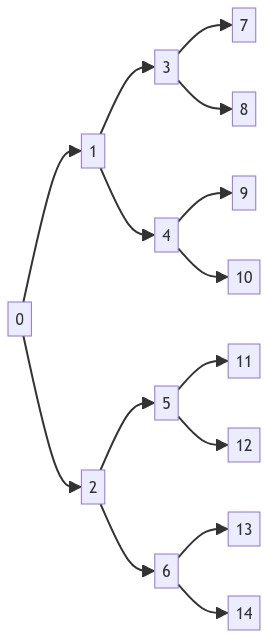

In [11]:
draw(tree)

# DFS shoud be more efficient

In [12]:
import math

def evaluate(node):
    return (node-10)**2   
    
def dfs(visited, node, nb_actions: int=2, max_depth: int=2):
    global i, best
    if node not in visited:
        if (
            (len(nx.shortest_path(tree, source=0, target=node)) <= max_depth)
            and 
            (node % 3 != 0 or node==0)
        ):
            for x in range(nb_actions):
                tree.add_edge(node, i+x+1, action=f"{node}->{i+x+1}")
                print(i+x+1, evaluate(i+x+1), best)
                if evaluate(i+x+1) > best:
                    visited.add(i+x+1)
                else:
                    best = evaluate(i+x+1)
            i += nb_actions
        visited.add(node)
        for neighbor in tree.successors(node):
            dfs(visited, neighbor, nb_actions=nb_actions, max_depth=max_depth)

tree = nx.DiGraph()
node = 0
best = evaluate(0)
visited = set()
tree.add_node(node)
i = 0
dfs(visited, 0, nb_actions=3, max_depth=3)

1 81 100
2 64 81
3 49 64
4 36 49
5 25 36
6 16 25
7 9 16
8 4 9
9 1 4
10 0 1
11 1 0
12 4 0
13 9 0
14 16 0
15 25 0


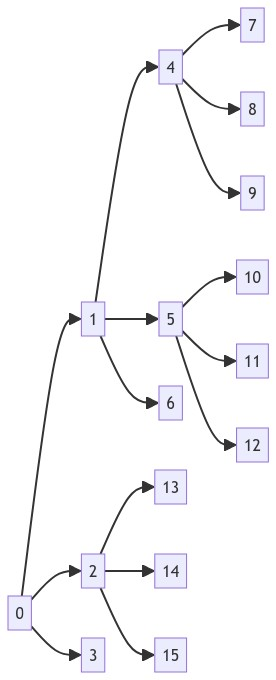

In [13]:
draw(tree)

# DFS : Build first, visit after

In [14]:
def build_tree(nb_actions: int, depth: int) -> nx.DiGraph:
    tree = nx.DiGraph()
    tree.add_node(0)
    
    nodes_to_explore = Queue()
    nodes_to_explore.put(0)
    i = 0
    while not nodes_to_explore.empty():
        n = nodes_to_explore.get()
        if len(nx.shortest_path(tree, source=0, target=n)) > depth:
            break
        for action in range(nb_actions):
            tree.add_edge(n, i+action+1, action=f"{n}->{i+action+1}")
            nodes_to_explore.put(i+action+1)
        i += nb_actions
    
    return tree

In [15]:
%%time
tree = build_tree(6,3)

CPU times: user 827 µs, sys: 0 ns, total: 827 µs
Wall time: 831 µs


In [16]:
# draw(tree)

# separate build edge and visit nodes

In [17]:
def draw_tree(tree):

    graph_txt = "graph LR;"+";".join([
        f"{str(edge[0]).replace('<','').replace('>','')}"
        f"-"
        f"- {tree.edges[edge]['weight']} -"
        f"->{str(edge[1]).replace('<','').replace('>','')}"
        for edge in tree.edges
    ])
    
    graphbytes = graph_txt.encode("ascii")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    url = "https://mermaid.ink/img/" + base64_string

    response = requests.get(url, stream=True)

    with open('tmp.png', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    return Image.open('tmp.png')

In [18]:
def evaluate(node):
    return -node**2 if node>0 else -100

def explore_decision_tree(
    nb_actions: int,
    max_successive_actions: int,
    explore_all_branches: bool = False,
) -> tuple[nx.DiGraph, int, float]:


    tree = nx.DiGraph()
    tree.add_node(0, reward=evaluate(0))

    nodes_to_explore = set()
    nodes_to_explore.add(0)

    max_reward = evaluate(0)

    def recursive(nodes_to_explore, max_reward, node):
        global best_reward, best_node
        best_reward = max_reward
        if node in nodes_to_explore:
            all_evaluated = len(list(tree.successors(node))) == nb_actions
            max_successive_actions_reached = (
                len(nx.shortest_path(tree, source=0, target=node)) 
                > max_successive_actions
            )

            done = node in [2, 4, 7, 8]
            # done = node %7 == 0 and node>0

            reward = tree.nodes[node]['reward']
            if done and reward > max_reward:
                max_reward = reward
                best_node = node
            not_better = reward < max_reward and node > 0
            if explore_all_branches:
                not_better = False
            
            if ( all_evaluated or max_successive_actions_reached or done or not_better):
                nodes_to_explore.remove(node)
                next_node = nx.ancestors(tree, node).intersection(nodes_to_explore)
                if next_node:
                    recursive(nodes_to_explore, max_reward, max(next_node))
            else:
                new_node_index = tree.number_of_nodes()
                tree.add_node(new_node_index, reward=evaluate(new_node_index))
                tree.add_edge(
                    node,
                    new_node_index,
                    weight=len(list(tree.successors(node)))
                )
                nodes_to_explore.add(new_node_index)
                
                recursive(nodes_to_explore, max_reward, new_node_index)

    recursive(nodes_to_explore, max_reward, 0)

    
    return tree, best_node, best_reward

2 -4


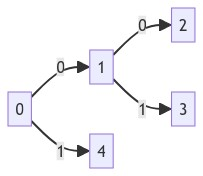

In [19]:
tree, best_node, best_reward = explore_decision_tree(
    nb_actions=2,
    max_successive_actions=5,
    explore_all_branches=False
)
print(best_node, best_reward)
draw_tree(tree)


# Regulation Environment

In [20]:
from rlway.pyosrd import OSRD
from rlway.schedules import schedule_from_osrd, Schedule
from rlway.regul_env import RegulEnv

In [21]:
import gymnasium as gym
from gymnasium import spaces

class RegulationEnv(gym.Env):

    def __init__(
        self,
        initial_schedule,
        delayed_schedule,
        stations,
    ):
        self._initial_schedule = initial_schedule
        self._delayed_schedule = delayed_schedule
        self._schedule = delayed_schedule
        self._stations = stations

        self.action_space = spaces.Discrete(2)

    @property
    def schedule(self) -> Schedule:
        return self._schedule

    @property
    def initial_schedule(self) -> Schedule:
        return self._initial_schedule

    @property
    def stations(self):
        return self._stations
    
    @property
    def total_delay(self):
        return self._schedule.total_delay_at_stations(
            self._initial_schedule,
            self._stations
        )
    
    def reset(self):
        self._schedule = self._delayed_schedule

    def set_state(self, schedule: Schedule):
        self._schedule = schedule
    
    def step(self, action):

        where, train0, train1 = self._schedule.earliest_conflict()
        print(self._schedule.earliest_conflict())

        if (
            self._schedule.train_delay(train0, self._initial_schedule)
            > self._schedule.train_delay(train1, self._initial_schedule)
        ):
            most_delayed, least_delayed = train0, train1
        else:
            most_delayed, least_delayed = train1, train0
        
        if action == 0:
            self._schedule = \
                self._schedule.shift_train_after(
                    most_delayed,
                    least_delayed,
                    where
                )
        else:
            self._schedule = \
                self._schedule.shift_train_after(
                    least_delayed,
                    most_delayed,
                    where
                )
        
        reward = - self.total_delay
        self._done = self.schedule.earliest_conflict()[0] is None
        
        return _, reward, self._done, {}
    
    def render(self):
        self._schedule.plot()

In [23]:
sim = OSRD(use_case='cvg_dvg', dir='tmp2')

[15:14:09,413] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp2/infra.json
[15:14:09,459] [INFO]              [FullInfra] parsing infra
[15:14:09,589] [INFO]              [FullInfra] adaptation to kotlin
[15:14:09,642] [INFO]              [FullInfra] loading signals
[15:14:09,658] [INFO]              [FullInfra] building blocks
[15:14:09,667] [INFO]  [StandaloneSimulationCommand] Loading input: tmp2/simulation.json
[15:14:09,685] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.0
[15:14:09,742] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.1
[15:14:09,750] [INFO]  [StandaloneSimulationCommand] All simulations completed
[15:14:09,751] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp2/results.json


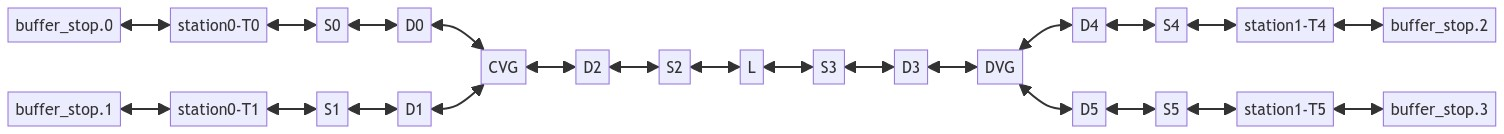

In [24]:
sim.draw_infra_points()

In [25]:

sim.add_train(
    label='train2',
    locations=[('T1', 300), ('T4', 480)],
    departure_time=200
)
sim.run()

[15:14:10,720] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp2/infra.json
[15:14:10,756] [INFO]              [FullInfra] parsing infra
[15:14:10,833] [INFO]              [FullInfra] adaptation to kotlin
[15:14:10,871] [INFO]              [FullInfra] loading signals
[15:14:10,878] [INFO]              [FullInfra] building blocks
[15:14:10,885] [INFO]  [StandaloneSimulationCommand] Loading input: tmp2/simulation.json
[15:14:10,898] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.0
[15:14:10,956] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.1
[15:14:10,963] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.2
[15:14:10,967] [INFO]  [StandaloneSimulationCommand] All simulations completed
[15:14:10,967] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp2/results.json


<Axes: xlabel='Time'>

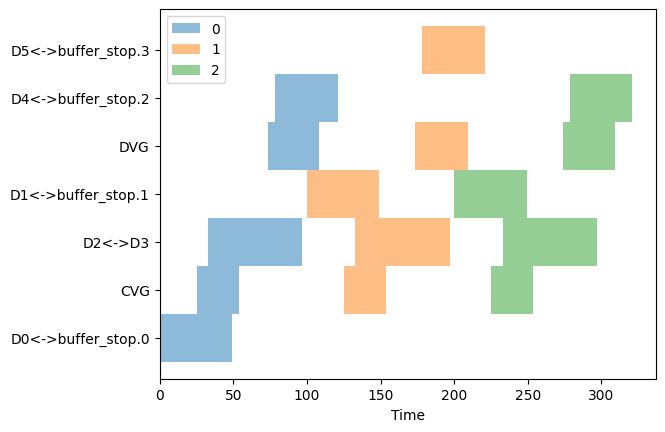

In [26]:
s = schedule_from_osrd(sim)
s.plot()

In [27]:
sim.reset_delays()
sim.add_delay('train0', time_threshold=10, delay=120.)
delayed = sim.delayed()
ds = schedule_from_osrd(delayed)

In [28]:
env = RegulationEnv(
    initial_schedule=s,
    delayed_schedule=ds,
    stations=['D4<->buffer_stop.2', 'D5<->buffer_stop.3']
)

('CVG', 1, 0)
-203.5945088038074 False
('D1<->buffer_stop.1', 1, 2)
-236.46040435012998 False
('D2<->D3', 1, 2)
-251.4168876830176 True


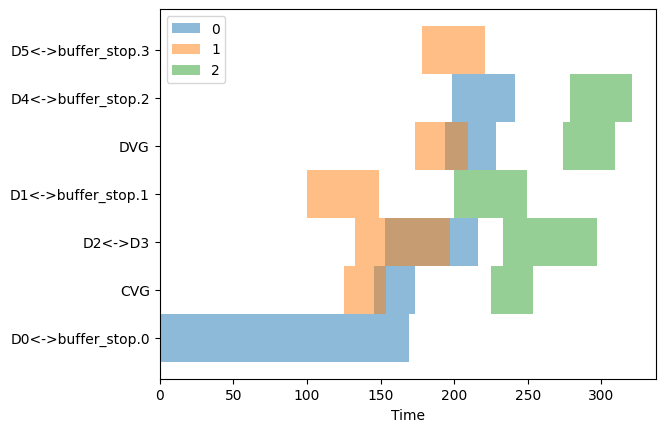

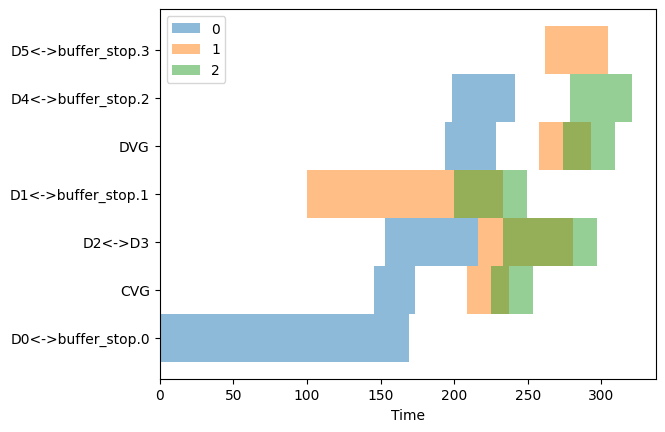

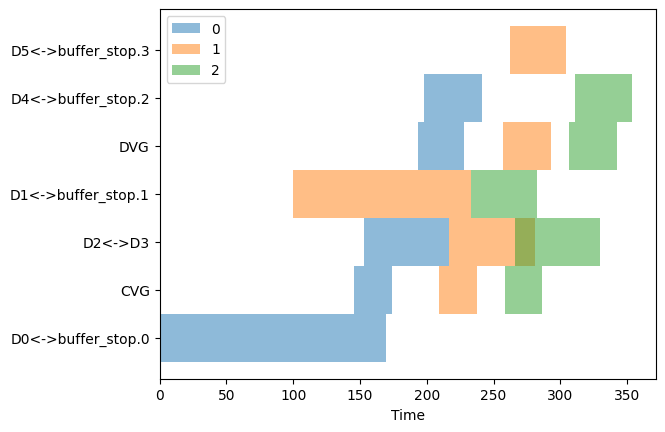

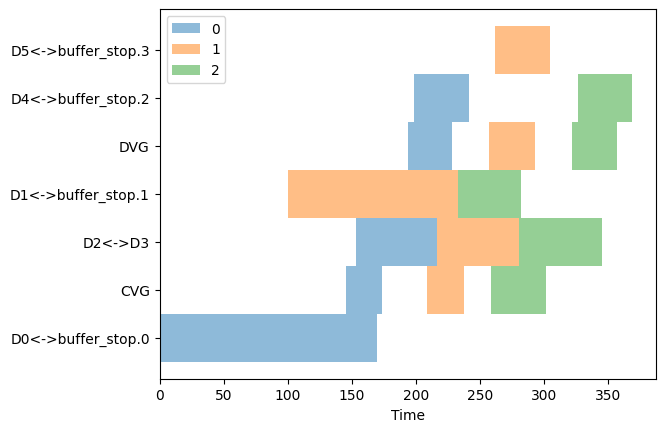

In [29]:
env.reset()
env.render()
for action in [1,1,1,1]:
    
    _, reward, done, _ = env.step(action)
    env.render()
    print(reward, done)
    if done:
        break

In [30]:
s.is_just_after_a_point_switch(1,2,'D2<->D3',)

False

In [31]:
from rlway.schedules import step_type


In [32]:
def previous_stop(schedule: Schedule, train, zone, step_type) -> str | None:
    
    if zone not in schedule.trajectory(train=train):
        return
    idx = schedule.trajectory(train=train).index(zone)
    return next(z for z in schedule.trajectory(train=train)[:idx][::-1] if step_type.loc[z, train] != 'switch')

def previous_station(schedule: Schedule, train, zone, step_type) -> str | None:
    
    if zone not in schedule.trajectory(train=train):
        return
    idx = schedule.trajectory(train=train).index(zone)
    return next(z for z in schedule.trajectory(train=train)[:idx][::-1] if step_type.loc[z, train] =='station')

In [33]:
previous_stop(s, 1, 'D5<->buffer_stop.3', step_type=step_type(sim))
previous_station(s, 1, 'D5<->buffer_stop.3', step_type=step_type(sim))

'D1<->buffer_stop.1'

In [34]:
step_type(sim)

,0,1,2
D0<->buffer_stop.0,station,NaN,NaN
CVG,switch,switch,switch
D2<->D3,signal,signal,signal
D1<->buffer_stop.1,NaN,station,station
DVG,switch,switch,switch
D4<->buffer_stop.2,station,NaN,station
D5<->buffer_stop.3,NaN,station,NaN


In [35]:
s.draw_graph()

In [36]:
import pandas as pd

def give_priority(
    self,
    train_with_priority: int | str,
    other_train: int | str,
    zone: int | str,
    step_type: pd.DataFrame
):
    other_train_waits_at = previous_stop(
        self,
        other_train,
        zone,
        step_type
    )

    if step_type.loc[zone,other_train] == 'switch':
        zone_ref = self.next_block(other_train, zone)
    else:
        zone_ref = zone
        
    other_train_wait_duration =(
        self.ends.loc[zone_ref, train_with_priority]
        - self.starts.loc[zone_ref, other_train]
    )
    
    
    new_schedule = self.add_delay(
        other_train,
        other_train_waits_at,
        other_train_wait_duration
    )

    return new_schedule

('D1<->buffer_stop.1', 2)

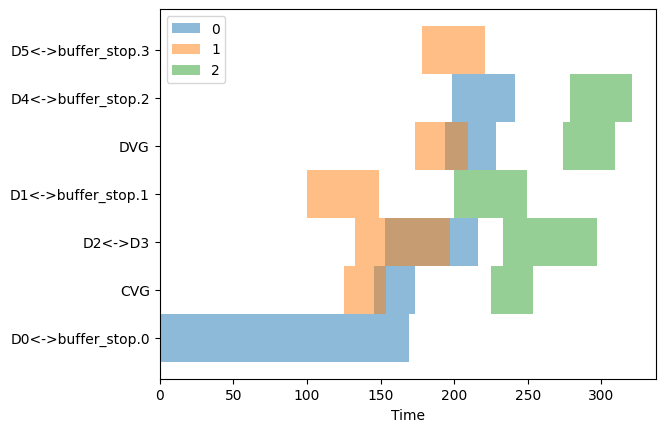

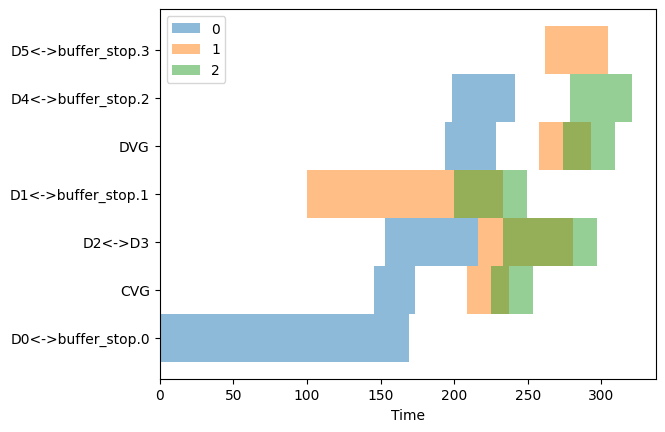

In [38]:
ds.plot()
d = give_priority(ds, 0, 1, 'CVG', step_type(sim))
d.plot()
d.first_conflict(1)


# c2y13s

In [90]:
sim = OSRD(use_case='c2y13s', dir='tmp3')

[15:42:33,276] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp3/infra.json
[15:42:33,319] [INFO]              [FullInfra] parsing infra
[15:42:33,398] [INFO]              [FullInfra] adaptation to kotlin
[15:42:33,442] [INFO]              [FullInfra] loading signals
[15:42:33,449] [INFO]              [FullInfra] building blocks
[15:42:33,454] [INFO]  [StandaloneSimulationCommand] Loading input: tmp3/simulation.json
[15:42:33,467] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.11
[15:42:33,537] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.12
[15:42:33,550] [INFO]  [StandaloneSimulationCommand] All simulations completed
[15:42:33,550] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp3/results.json


In [91]:
sim.space_time_chart_plotly(0)

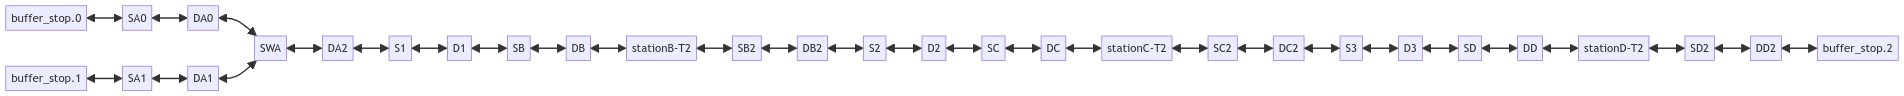

In [92]:
sim.draw_infra_points()

In [93]:
from rlway.pyosrd.set_trains import copy_train

In [94]:
copy_train(sim, 'train0', 'new_train0', 1000)
copy_train(sim, 'train1', 'new_train1', 1100)

In [95]:
sim.run()

[15:42:34,243] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp3/infra.json
[15:42:34,282] [INFO]              [FullInfra] parsing infra
[15:42:34,373] [INFO]              [FullInfra] adaptation to kotlin
[15:42:34,433] [INFO]              [FullInfra] loading signals
[15:42:34,444] [INFO]              [FullInfra] building blocks
[15:42:34,453] [INFO]  [StandaloneSimulationCommand] Loading input: tmp3/simulation.json
[15:42:34,476] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.11
[15:42:34,591] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.12
[15:42:34,615] [INFO]  [StandaloneSimulationCommand] All simulations completed
[15:42:34,615] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp3/results.json


In [96]:
sim.trains

['train0', 'new_train0', 'train1', 'new_train1']

In [99]:
sim.space_time_chart_plotly(0)

<Axes: xlabel='Time'>

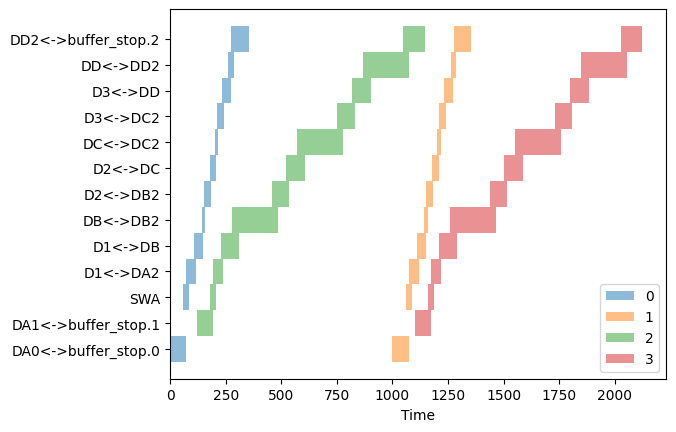

In [98]:
s = schedule_from_osrd(sim)
s.sort().plot()